### notebook purpose

- evaluate mask types across...
    - square v rect central region
    - different sampling patterns across e1, e2

In [43]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics_imgs, plot_row_qdess, scale_0_1
from utils.data_io import get_mtr_ids_and, load_imgs, load_qdess
from utils.transform import reshape_adj_channels_to_complex_vals, \
                            reshape_complex_vals_to_adj_channels

In [51]:
accel = 4
path_base = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)

path_gt = path_base + 'gt/'

CALIB = 64
path_bl = path_base + 'calib/40/'
path_new = path_base + 'calib/{}/'.format(CALIB)

### load imgs, calc metrics

In [52]:
mtr_id_list = get_mtr_ids_and(path_bl, path_new)

imgs_gt = load_imgs(mtr_id_list, path=path_gt)
imgs_bl = load_imgs(mtr_id_list, path=path_bl)
imgs_new = load_imgs(mtr_id_list, path=path_new)
    
metrics_bl = calc_metrics_imgs(imgs_gt, imgs_bl)
metrics_new = calc_metrics_imgs(imgs_gt, imgs_new)

### avg metrics across all samples

In [53]:
print(mtr_id_list)

mu_bl = np.around(np.mean(metrics_bl, 0), 4)
mu_new = np.around(np.mean(metrics_new, 0), 4)
mu_diff = mu_new - mu_bl
print('\n', mu_bl, '\n', mu_new, '\n\n', mu_diff, '\n', mu_new/mu_bl-1)

['005', '006', '030', '034', '048', '052', '065', '066', '080', '096', '099', '120']

 [[ 0.8622  0.9614  0.8202 29.8892]
 [ 0.712   0.9242  0.7457 31.3503]] 
 [[ 0.8794  0.9661  0.8285 30.0018]
 [ 0.7376  0.931   0.753  31.4983]] 

 [[0.0172 0.0047 0.0083 0.1126]
 [0.0256 0.0068 0.0073 0.148 ]] 
 [[0.01994897 0.0048887  0.01011948 0.00376725]
 [0.03595506 0.00735771 0.00978946 0.00472085]]


### indiv sample metrics

In [54]:
for idx_s, mtr_id in enumerate(mtr_id_list):
    
    print(mtr_id)
    print(metrics_bl[idx_s])
    print(metrics_new[idx_s])
    sys.exit()

005
[[ 0.8605  0.9605  0.8178 29.4902]
 [ 0.5311  0.8975  0.6602 29.7837]]
[[ 0.8681  0.9641  0.8214 29.4758]
 [ 0.5319  0.8906  0.6879 29.4383]]


SystemExit: 

### plot

SystemExit: 

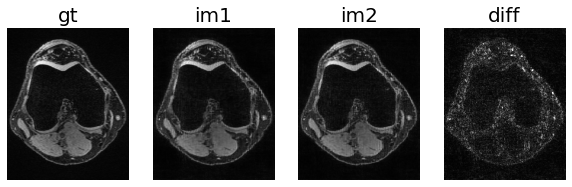

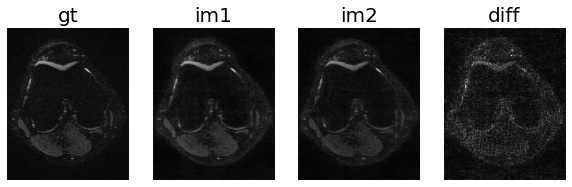

In [56]:
title_list = ['gt', 'im1', 'im2']
clim_list = [None] * len(title_list)
DIFF_MAP = True

for idx_s in np.arange(imgs_gt.shape[0]):
    for idx_e in np.arange(imgs_gt.shape[1]):
        
        im_gt, im1, im2 = imgs_gt[idx_s, idx_e], \
                          imgs_bl[idx_s, idx_e], \
                          imgs_new[idx_s, idx_e]
#         im_gt, im1, im2 = scale_0_1(im_gt), scale_0_1(im1), scale_0_1(im2)
        arr_list = [im_gt, im1, im2]
        
        if DIFF_MAP:
            C = 4 # constant for plotting on clim=(0,1)
            im_diff = C * np.abs(scale_0_1(im1) - scale_0_1(im2))
            arr_list.append(im_diff)
            title_list.append('diff')
            clim_list.append((0,1))
                
        plot_row_qdess(arr_list, title_list, clim_list)
        
    sys.exit()